# K-Means

## About the model

K-Means is a famous algorithm used for clustering. It was originally invented by Stuart Lloyd in 1957, but was never published until the 1980s. In the meantime, E. W. Forgy published more or less the same technique, and therefore, K-Means is sometimes referred to as the Lloyd-Forgy method.

## Pros

- Number of clusters can be defined
- Scales well
- Easy to implement
- Easy to interpret

## Cons

- Number of clusters has to be defined
- Is biased towards spherical clusters of the same size
- Appropriate distance measure has to be picked
- Convergence is dependent on initialization

## Introduction 

K-Means is a very popular clustering algorithm. It clusters $n$ data points into $K$ distinct clusters. These clusters are represented by the mean of the elements in it, also called centroids.

To show this, let's plot some data.

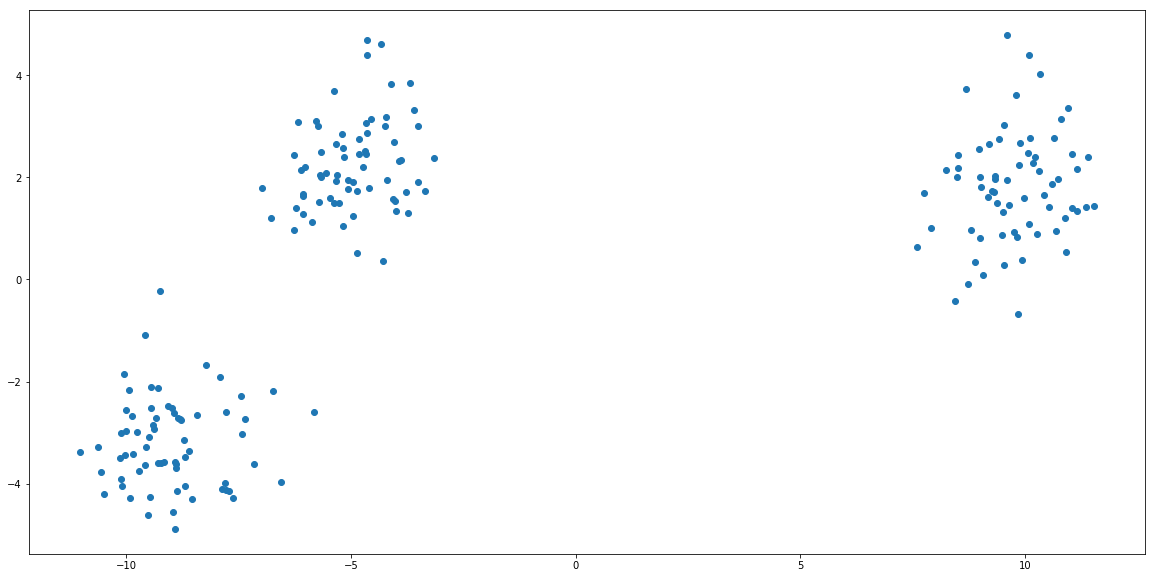

In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, _ = make_blobs(n_samples=200, n_features=2, centers=3)
fig = plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1])
plt.savefig("../kmeans_intro.png", dpi=100)
plt.show()

As we can see, there seems to be 3 distinct groups. In K-Means, they would be represented by taking the average point of all points belonging to a certain cluster. These are called the centroids.

Here is the algorithm to find these centroids:

- create K centroids
- assign each point to a centroid (and therefore a cluster)
- update centroids by average points in each each cluster
- repeat until clusters have converged

Now, let's how this would work in code.

## Implementation from "skratch"

First, we create a `KMeans` object. All we need to define is the value of $K$, some random seed, and how many times we want to run the algorithm. To have more insights on why several runs are necessary, go to the FAQ.

In [1]:
import sys ; sys.path.append("../source")
import numpy as np
import copy

from utils.distances import euclidean


class KMeans:

    def __init__(self, k=3, seed=0, n_runs=10):

        self.k = k
        self.rnd = np.random.RandomState(seed)
        self.n_runs = n_runs

As any model, we need to define how it fits the training data. In K-Means, we run the algorithm multiple times, and then pick the best solution given a performance measure.

In [35]:
    def fit(self, X, y=None):

        self.score_ = float('inf')  # initialize as worst possible performance/score

        for run in range(self.n_runs):

            for c, l in self._fit(X, y):
                centroids, labels = c, l

            performance = self._performance(X, centroids, labels)

            if performance < self.score_:

                self.score_ = performance
                self.centroids_ = centroids
                self.labels_ = labels

        return self

The algorithm is defined in the `_fit` function. As explained before, we initialize the centroids. Then we assign each data point to one of the clusters. We then update the centroids, and continue until the data points do not change clusters anymore.

In [36]:
    def _fit(self, X, y=None):

        centroids = self._initialize_centroids(X)
        labels = self._compute_labels(X, centroids)
        old_labels = np.full_like(labels, -1)

        while any(old_labels != labels):

            old_labels = labels
            centroids = self._compute_centroids(X, labels)
            labels = self._compute_labels(X, centroids)

            yield centroids, labels

In order to initialize the centroids, there are multiple ways. In our case, we will simply pick $K$ random data points. For more ways to initialize the centroids, go to the FAQ.

In [37]:
    def _initialize_centroids(self, X):

        self.rnd.shuffle(X.copy()) # copy the data to not shuffle it in place
        return X[:self.k]

Since K-Means relies on finding the closest data points to a certain centroid, we need to define a distance measure. Typically, this distance measure is the `Euclidean` distance as it reduces the within-cluster variance.

In [38]:
    def _distance(self, a, b):

        return euclidean(a, b)

After we've initialized centroids, we need to define which cluster each data point belongs to. To do so, we compute the distance between each point and all centroids, and assign the data point to the cluster defined by the centroid to which it is closest.

In [39]:
    def _compute_labels(self, X, centroids):

        labels = []

        for x in X:

            distances = [self._distance(x, centroid) for centroid in centroids]
            label = np.argmin(distances)
            labels.append(label)

        return np.array(labels)

On the other hand, to update the centroids, we compute the average data point assigned to that specific centroid.

In [40]:
    def _compute_centroids(self, X, labels):

        centroids = []

        for i in range(self.k):

            centroid = np.mean(X[labels == i], axis=0)
            centroids.append(centroid)

        return np.array(centroids)

To determine which run was most successful, we must define a performance measure. Typically, this performance measure is the intro-cluster mean squared distance. In other words, we calculate the distance between each point and their closest centroid, square it, and then take the average.

In [2]:
    def _inertia(self, X, centroids, labels):

        distances = []

        for i, centroid in enumerate(centroids):

            distances.extend([self._distance(x, centroid) for x in X[labels == i]])

        return np.sum(distances)

If we are given a new data point, we can determine to which cluster it belongs by using the `_compute_labels` function we defined previously.

In [42]:
    def predict(self, X):

        return self._compute_labels(X, self.centroids_)

## FAQ

### What is the right value of K?

K is a hyperparameter and therefore, it can be tuned. Typically, one will try multiple values of $K$ and will use the [Elbow Method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b) to find the best value.

### Why are several runs needed?

The algorithm gives no guarantee to find the best clusters every time. Indeed, based on the first random clusters, the algorithm might converge to a different solution. This is why, K-Means is typically run multiple times in order to increase the chances to not get stuck with a bad solution.

### Can we use different distance metrics?

K-Means is [not guaranteed to converge with arbitrary distance metrics](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric). K-Means itself does not make use of distance measures per se, it only cares about reducing the within-cluster variance. It happens to be linked with the Euclidean distance, but this doesn't always work with arbitrary distances.

If you want to use arbitrary distances, you must use [K-Medoids](https://en.wikipedia.org/wiki/K-medoids). If you want to reduce the L1-norm, then you can use [K-Medians](https://en.wikipedia.org/wiki/K-medians_clustering).

## Useful resources

Wikipedia:

https://en.wikipedia.org/wiki/K-means_clustering   
https://en.wikipedia.org/wiki/K-means%2B%2B   

Tutorials:  

https://www.coursera.org/learn/machine-learning/lecture/93VPG/k-means-algorithm (Andrew Ng)   
https://www.r-bloggers.com/k-means-clustering-in-r/   
http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/kmeans.html   
https://www.datascience.com/blog/k-means-clustering   
https://www.dezyre.com/data-science-in-r-programming-tutorial/k-means-clustering-techniques-tutorial   
https://dataanalyticsmastery.wordpress.com/2017/05/25/complete-guide-to-kmeans-clustering/   

Implementations:

https://github.com/muesli/kmeans (Go)   
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html   
https://github.com/eriklindernoren/ML-From-Scratch/blob/master/mlfromscratch/unsupervised_learning/k_means.py   

Videos:
https://www.youtube.com/watch?v=_aWzGGNrcic
https://www.youtube.com/watch?v=hDmNF9JG3lo (Andrew Ng)
https://www.youtube.com/watch?v=9991JlKnFmk
https://www.youtube.com/watch?v=yR7k19YBqiw
https://www.youtube.com/watch?v=4R8nWDh-wA0